In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

In [2]:
youtube_data = pd.read_csv("youtube_dataset.csv", index_col="video_id")

In [3]:
youtube_data.head()

published_at  \
video_id                            
4NISmeBNXy8  2024-03-16T09:30:01Z   
PGHeFbpaH4Q  2024-03-15T18:30:15Z   
fl2afHLEjyM  2024-03-15T17:37:01Z   
6HgEZBxTsKQ  2024-03-15T17:03:52Z   
z3e2JfjHMP0  2024-03-15T17:00:48Z   

                                                         title  \
video_id                                                         
4NISmeBNXy8  আজ বাড়িতে সকালে রান্না খাওয়া হলো||বাড়িতে হঠ...   
PGHeFbpaH4Q  Quick and Easy Za'atar and Labneh Spaghetti | ...   
fl2afHLEjyM  Picking A Date Based On Our Cooking! (Mexican ...   
6HgEZBxTsKQ  After Sehri To Iftar Very Busy Routine " 1st J...   
z3e2JfjHMP0  Coolest Miniature: Watermelon Jelly Egg Ideas ...   

                           channel_id         channel_title  view_count  \
video_id                                                                  
4NISmeBNXy8  UCHxgoBn9vWA_gBaOI3phY6w    Sundarban Cooking         3253   
PGHeFbpaH4Q  UC1rIOwTqDuWkFj87HZYRFOg           NYT Cooking       39986   
fl2afHLEjyM  UCDP7DZOgj8VTyhyVNup83QQ             Amp World      157804   
6HgEZBxTsKQ  UCzR_69NUGuTW-AM_y8PCh5A  Cooking With Shabana       70457   
z3e2JfjHMP0  UC5nA6O_7aYs3zWEX83m3jnw    Miniature Cooking         9778   

             like_count  dislike_count  favorite_count  comment_count  \
video_id                                                                
4NISmeBNXy8       460.0            NaN               0           30.0   
PGHeFbpaH4Q      2126.0            NaN               0          155.0   
fl2afHLEjyM      4872.0            NaN               0          368.0   
6HgEZBxTsKQ      2687.0            NaN               0          311.0   
z3e2JfjHMP0       120.0            NaN               0           16.0   

             duration  ...                                channel_description  \
video_id               ...                                                      
4NISmeBNXy8  00:23:55  ...  Hi Friends,\n       Welcome to our channel  'S...   
PGHeFbpaH4Q  00:09:21  ...  All the food that’s fit to eat (yes, it’s an o...   
fl2afHLEjyM  00:18:30  ...  Your Favorite Squad, All In One Place! \nWelco...   
6HgEZBxTsKQ  00:23:50  ...  Assalam u Alaikum ♥️ Aap Sab Ka Welcome Mere C...   
z3e2JfjHMP0  00:08:06  ...  ❤️ Welcome to Miniature Cooking \n❤️ My channe...   

                    channel_published_at  videoCount  \
video_id                                               
4NISmeBNXy8  2021-07-01T06:23:14.495683Z         986   
PGHeFbpaH4Q         2019-01-09T17:26:44Z         451   
fl2afHLEjyM  2020-07-31T04:23:34.048892Z         958   
6HgEZBxTsKQ         2017-08-18T19:32:16Z        1423   
z3e2JfjHMP0  2021-06-07T03:36:25.859685Z         602   

                                                          tags category_id  \
video_id                                                                     
4NISmeBNXy8  ['আজ বাড়িতে সকালের রান্না খাওয়া হলো', 'Sunda...          26   
PGHeFbpaH4Q  ['cooking', 'cooks', 'recipes', 'recipe', 'how...          26   
fl2afHLEjyM  ['Amp World', 'Amp World News', 'Brent Rivera'...          24   
6HgEZBxTsKQ  ['Shabana', 'Cooking with shabana', 'Iftar', '...          22   
z3e2JfjHMP0  ['watermelon jelly', 'watermelon', 'dessert', ...          24   

            default_language  default_audio_language  license  content_rating  \
video_id                                                                        
4NISmeBNXy8              NaN                      bn  youtube              {}   
PGHeFbpaH4Q              NaN                      en  youtube              {}   
fl2afHLEjyM              NaN                     zxx  youtube              {}   
6HgEZBxTsKQ              NaN                     NaN  youtube              {}   
z3e2JfjHMP0              NaN                      en  youtube              {}   

            share_count  
video_id                 
4NISmeBNXy8         NaN  
PGHeFbpaH4Q         NaN  
fl2afHLEjyM         NaN  
6HgEZBxTsKQ         NaN  
z3e2JfjHMP0         NaN  

[

### Step 1:
## Preprocessing

In [4]:
from datetime import timedelta

# Remove duplicates
youtube_data.drop_duplicates(inplace=True)

# The data in 'channel_published_at' is messy and we will use RE to sort it out
# Define regex pattern to extract date part
pattern = r'^(\d{4}-\d{2}-\d{2})'

# Extract date part using regex
youtube_data['channel_published_at'] = youtube_data['channel_published_at'].str.extract(pattern)

# Convert 'published_at' and 'channel_published_at' to datetime
youtube_data['published_at'] = pd.to_datetime(youtube_data['published_at'])
youtube_data['channel_published_at'] = pd.to_datetime(youtube_data['channel_published_at'])
youtube_data['channel_published_at'] = youtube_data['channel_published_at'].dt.tz_localize('UTC')



# Extract new features from text columns
youtube_data['number_of_words_in_title'] = youtube_data['title'].apply(lambda x: len(x.split()))
youtube_data['number_of_words_in_channel_description'] = youtube_data['channel_description'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
youtube_data['number_of_tags'] = youtube_data['tags'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

# Convert 'duration' to seconds
def duration_to_seconds(duration):
    try:
        time_parts = duration.split(':')
        return int(time_parts[0]) * 3600 + int(time_parts[1]) * 60 + int(time_parts[2])
    except:
        return None

youtube_data['duration_seconds'] = youtube_data['duration'].apply(duration_to_seconds)

# Calculate the number of days since the first video in the dataset was published
youtube_data['days_since_published'] = (youtube_data['published_at'] - youtube_data['published_at'].min()).dt.days
# Calculate the number of days since the first video in the channel was published
youtube_data['days_since_channel_published'] = (youtube_data['published_at'] - youtube_data['channel_published_at']).dt.days

# Remove unnecessary columns
columns_to_drop = ['duration', 'favorite_count', 'dislike_count', 'channel_title', 'default_language', 
                   'default_audio_language', 'license', 'content_rating', 'share_count', 'channel_description']
youtube_data.drop(columns_to_drop, axis=1, inplace=True)

# Check for missing values
youtube_data.isnull().sum()

published_at                               0
title                                      0
channel_id                                 0
view_count                                 0
like_count                                40
comment_count                             43
definition                                 0
topic                                      0
subscriber_count                           0
total_channel_views                        0
channel_published_at                       0
videoCount                                 0
tags                                       0
category_id                                0
number_of_words_in_title                   0
number_of_words_in_channel_description     0
number_of_tags                             0
duration_seconds                           0
days_since_published                       0
days_since_channel_published               0
dtype: int64

### Step 2:
## Visuzaling

First we'll want to visualize the data.

Since our data have more then 3 dimetions, We need to use other methods for visualize it.

We will define pipeline for handling both the categorical and numerical columns

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

categorical_columns = ['category_id', 'topic', 'definition']

numerical_columns = ['view_count', 'like_count', 'comment_count', 'subscriber_count', 
                     'total_channel_views', 'videoCount', 'number_of_words_in_title',
                     'number_of_words_in_channel_description', 'number_of_tags', 
                     'duration_seconds', 'days_since_published', 'days_since_channel_published']

# Create pipelines for both numerical and categorical preprocessing
# For numerical features: impute missing values and apply MinMaxScaler
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Fill missing values with 0 -> videos without likes/comments have no relevant key
    ('scaler', MinMaxScaler())
])

# For categorical features: impute missing values and apply OneHotEncoder
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fill missing values with 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both pipelines into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)

X = preprocessor.fit_transform(youtube_data)

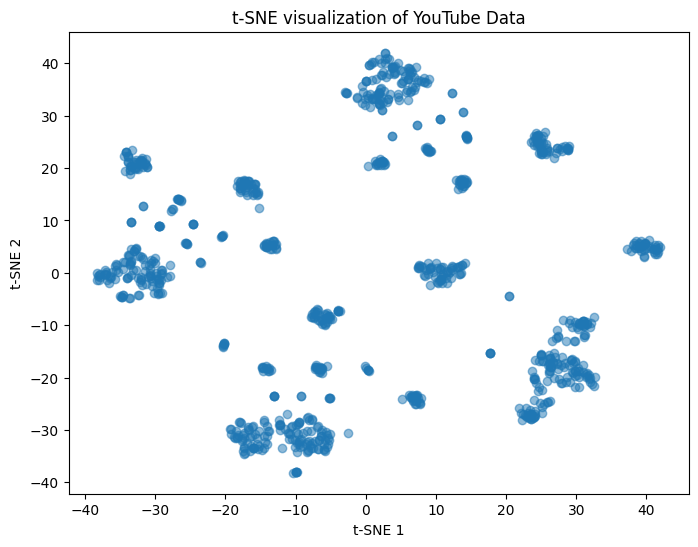

In [6]:
from sklearn.manifold import TSNE

# Applying t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(X)

# Plotting the results of t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE visualization of YouTube Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

By looking at the plot we can see there are a few separate clusters and a few outliers that seem outside the clusters.

t-SNE is a stochastic algorithm based on t-distribution, for better understanding we'll also apply PCA to the data

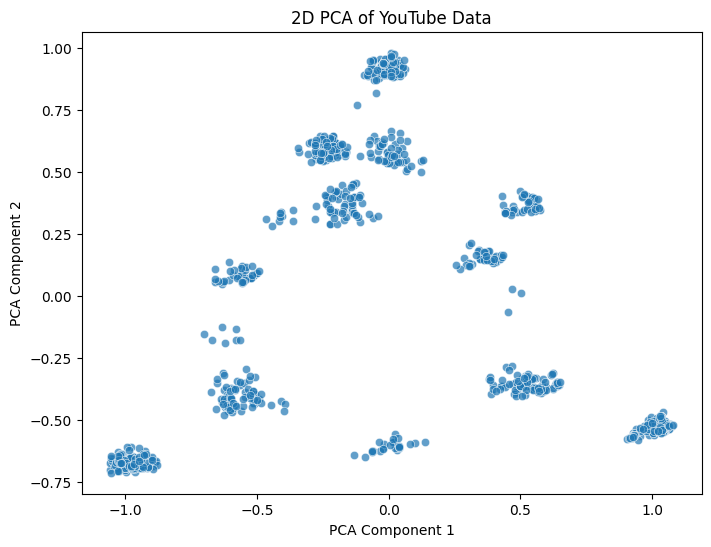

Total Variance captured from the data: 38.10%


In [7]:
from sklearn.decomposition import PCA

# Apply PCA on the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the first two PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA of YouTube Data')
plt.show()

# Print the percentage variance captured in PCA
print(f'Total Variance captured from the data: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%')

We can see a few clusters with high density within them, and a few outliers that seems not belonging to any cluster.

But, with only 2 principal components, we are able to capture only 38.1% of the variance from the original data. Let's check how much adding another dimention will help

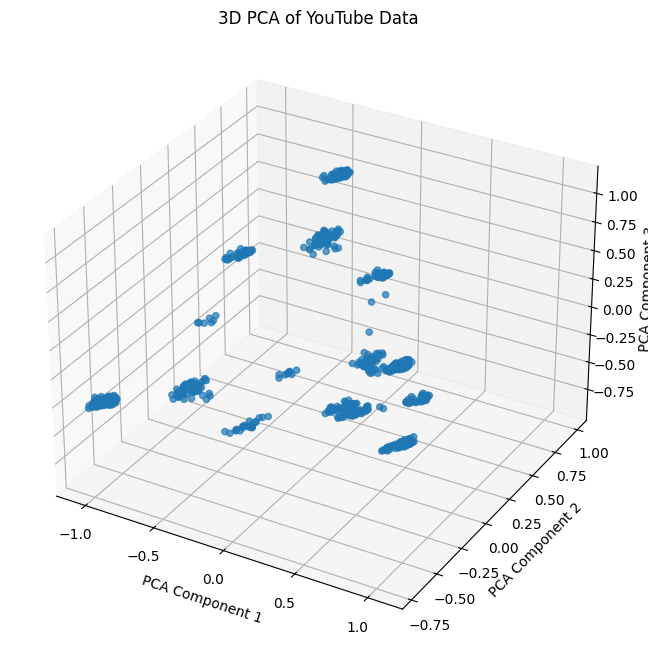

Total Variance captured from the data: 54.78%


In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Now apply PCA on the transformed data for 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Plot the first three PCA components in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the first three PCA components
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.7)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA of YouTube Data')
plt.show()

# Print the percentage variance captured in PCA
print(f'Total Variance captured from the data: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%')

By adding another principal component, we got better results and able to capture 54.78% of the data.

Because 3D is the maximun number of dimensions we can visualize, we will stay with that. And even with 54.78% of the variance, we can understand a lot about the data.

### Step 3:
## Clustering
Because the PCA is getting only 54.78% of the variance, we are losing a significant portion of the information present in the original data.

We will apply the algorithms to the entire data set - X and only visualize them into 3D

#### KMeans

From the plots above, we can see that the clusters have a spherical shape and are well-separated, so the KMeans algorithm could be a good fit for our situation.

To determine the best K parameter, we will plot the inertia - within cluster sum of squares, for every K and search for the elbow. We will also plot the scaled inertia.

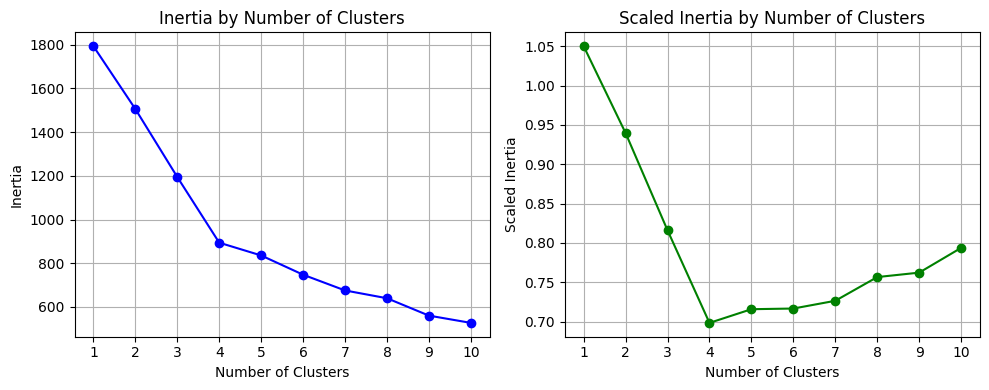

In [9]:
from sklearn.cluster import KMeans

alpha_k = 0.05  # Parameter for scaled inertia
inertia_values = []
scaled_inertia_values = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)
    
    # Calculating scaled inertia
    inertia_o = np.square(X - X.mean(axis=0)).sum()
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    scaled_inertia_values.append(scaled_inertia)

# Plot the Elbow Curve for both original inertia and scaled inertia values side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot for original inertia
axes[0].plot(range(1, 11), inertia_values, marker='o', color='blue')
axes[0].set_title('Inertia by Number of Clusters')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].set_xticks(range(1, 11))
axes[0].grid(True)

# Plot for scaled inertia
axes[1].plot(range(1, 11), scaled_inertia_values, marker='o', color='green')
axes[1].set_title('Scaled Inertia by Number of Clusters')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Scaled Inertia')
axes[1].set_xticks(range(1, 11))
axes[1].grid(True)

plt.tight_layout()
plt.show()

According to the "elbow" method, the right number of clusters is 4.

The problem is the elbow method only refers to the within-cluster sum of squares. However, it doesn't account for the second aspect, which is the separation between clusters.

That's why we will also use the silhouette metric for evaluation.

For n_clusters = 2, the average silhouette_score is: 0.1908151328770061
For n_clusters = 3, the average silhouette_score is: 0.27825854059717653
For n_clusters = 4, the average silhouette_score is: 0.3694775704826045
For n_clusters = 5, the average silhouette_score is: 0.36395633387003484
For n_clusters = 6, the average silhouette_score is: 0.37023829627991667
For n_clusters = 7, the average silhouette_score is: 0.37647887787592255
For n_clusters = 8, the average silhouette_score is: 0.3603958947792616
For n_clusters = 9, the average silhouette_score is: 0.3660977702796153
For n_clusters = 10, the average silhouette_score is: 0.4168789788930136
For n_clusters = 11, the average silhouette_score is: 0.38847353289391184
For n_clusters = 12, the average silhouette_score is: 0.40781523643306844
For n_clusters = 13, the average silhouette_score is: 0.42827059074959906
For n_clusters = 14, the average silhouette_score is: 0.45726525338150675
For n_clusters = 15, the average silhouette_score i

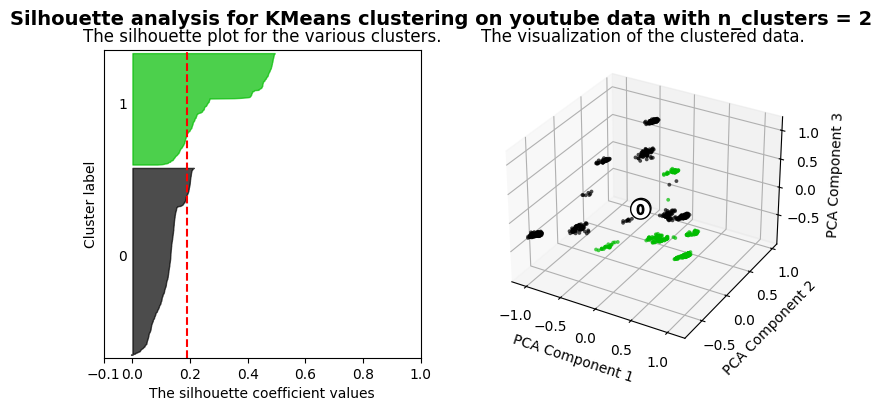

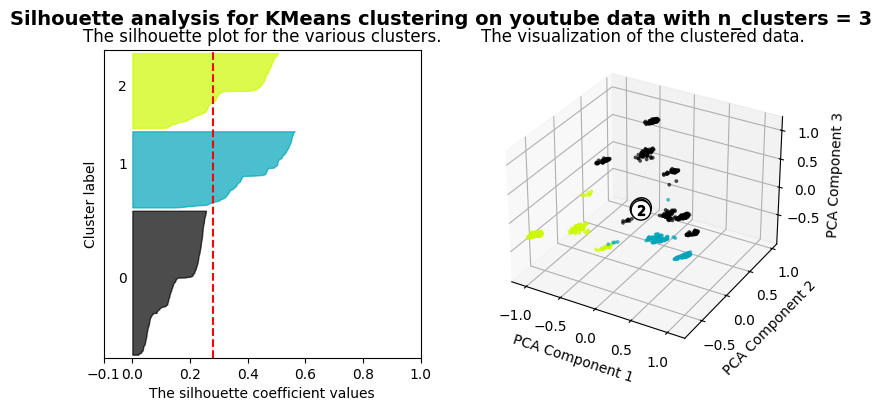

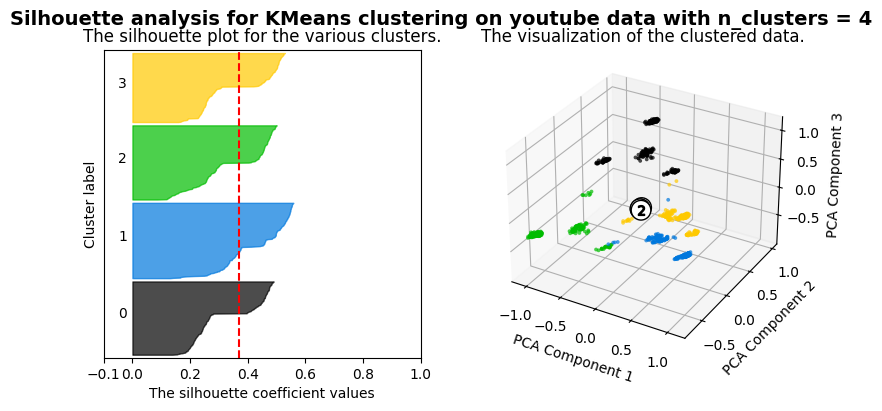

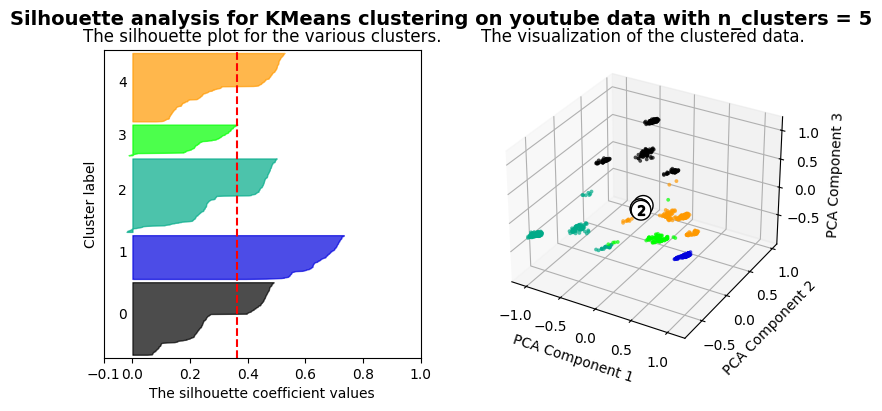

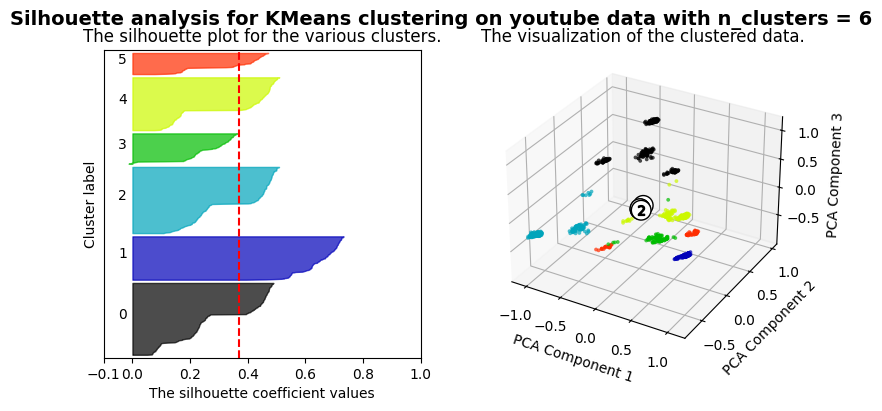

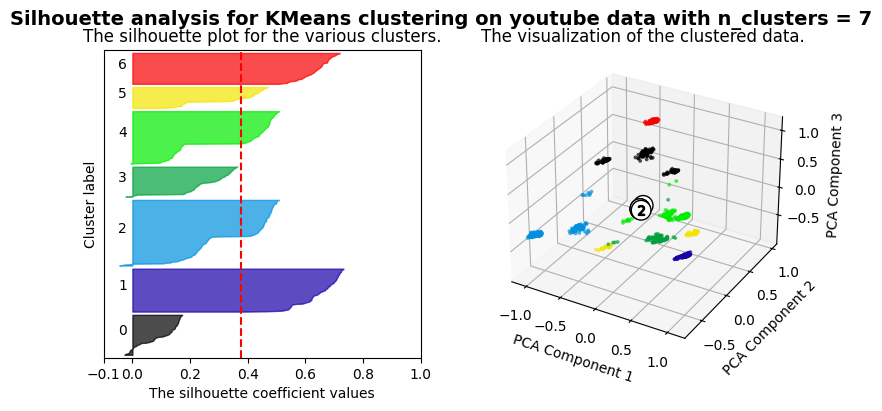

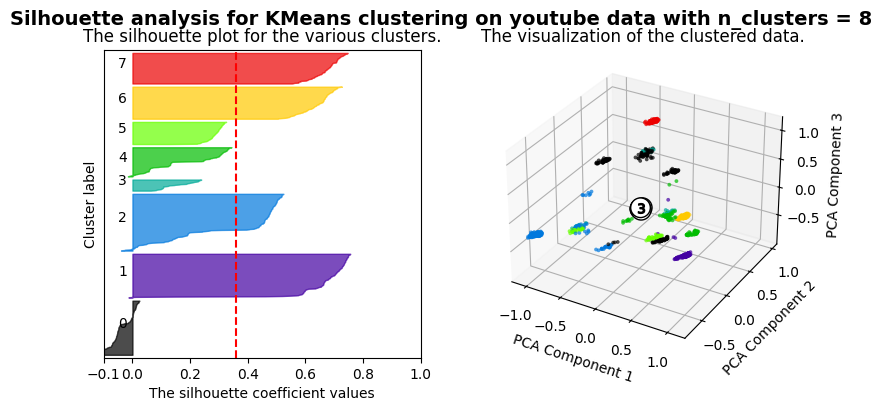

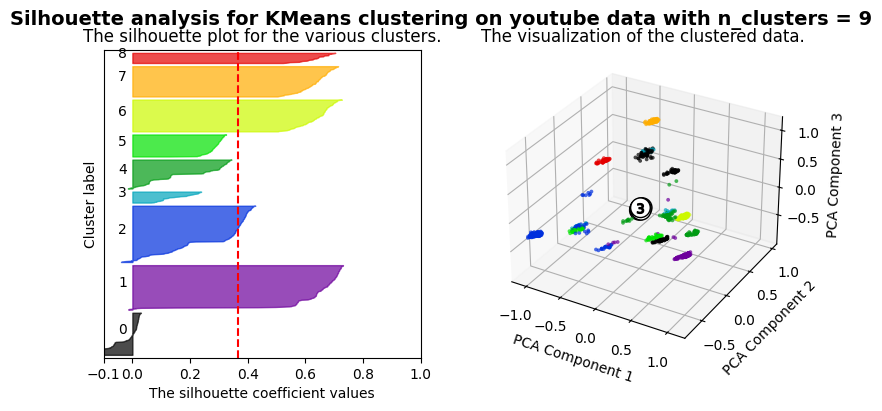

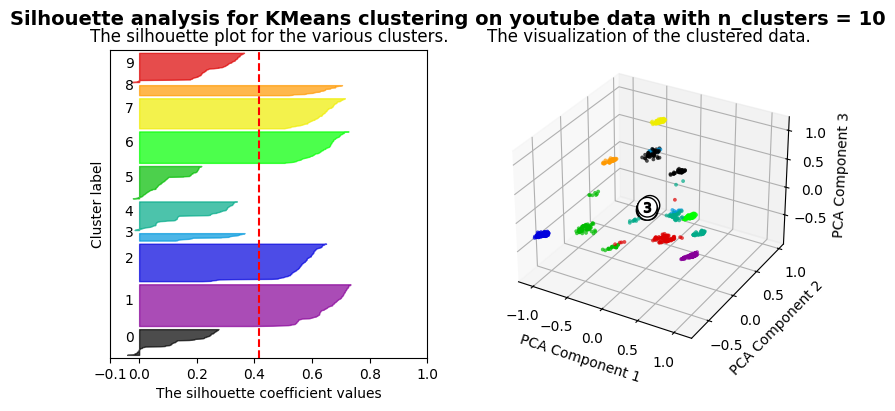

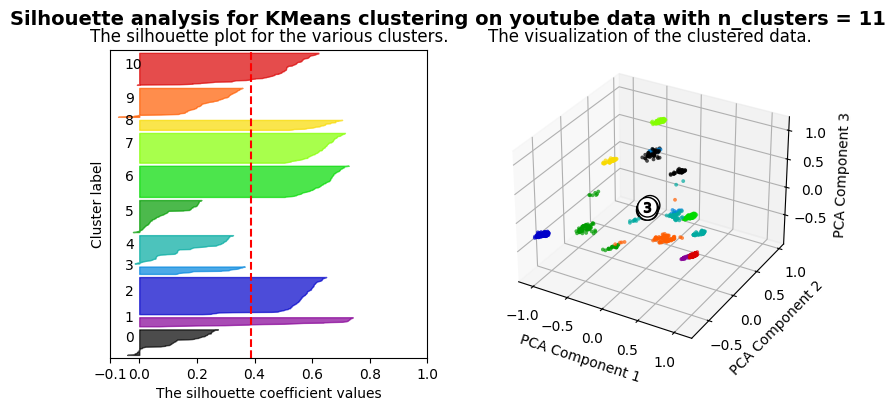

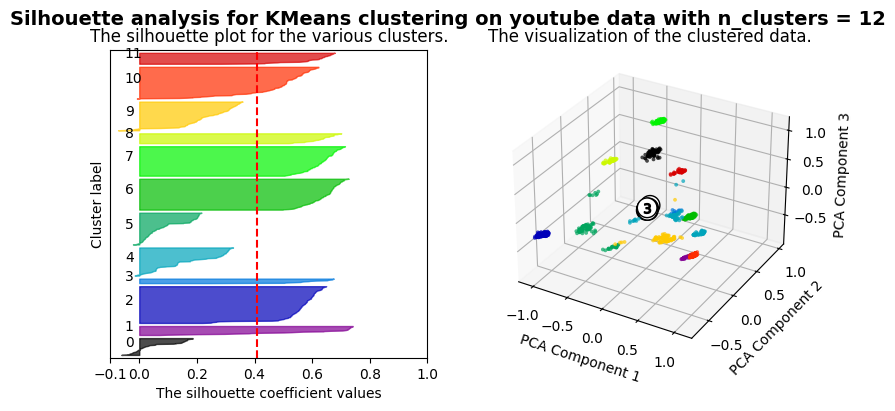

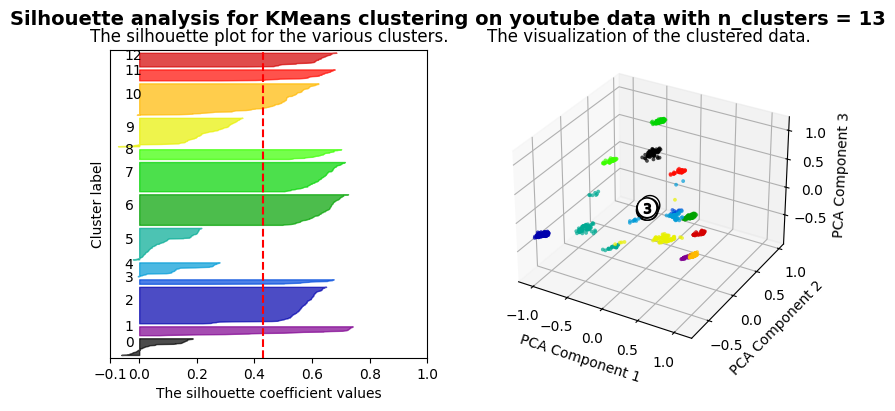

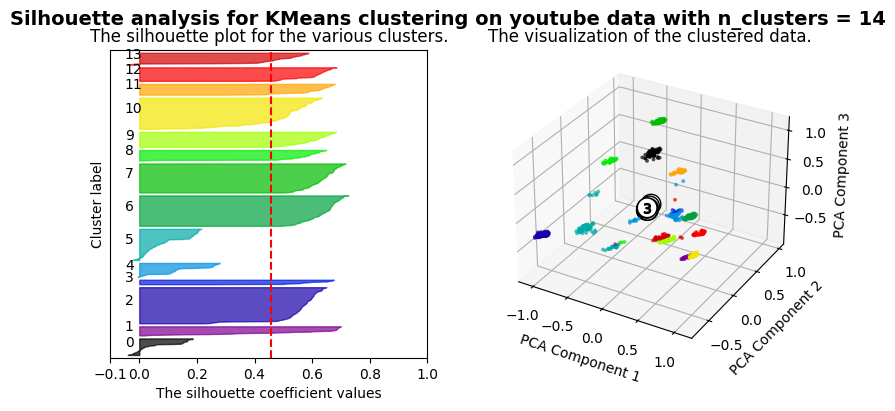

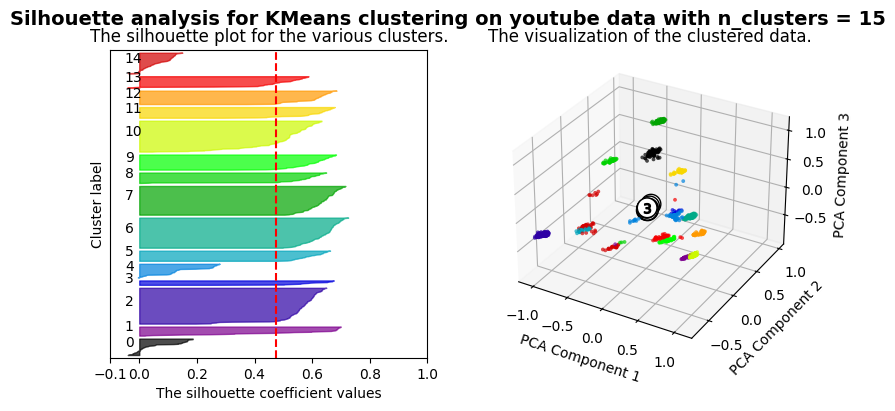

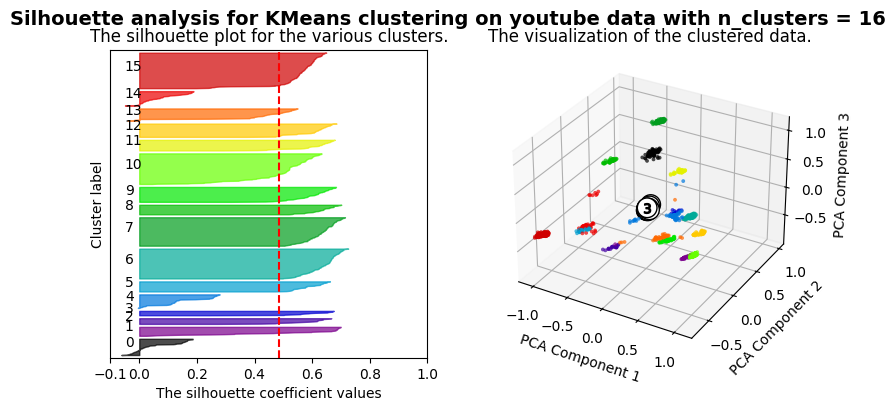

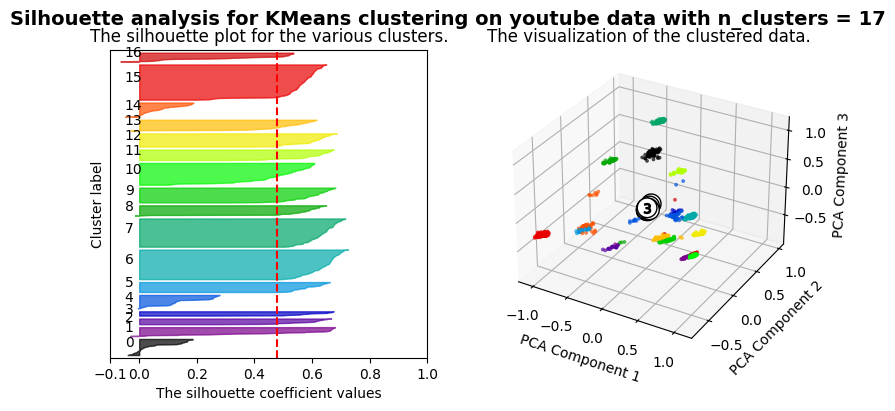

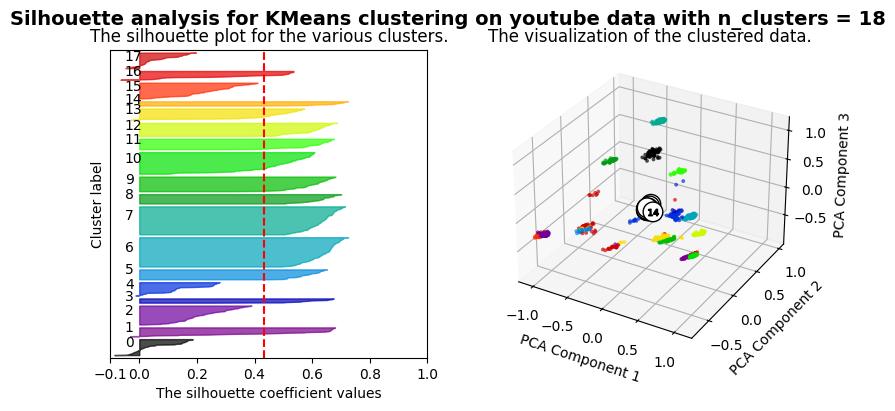

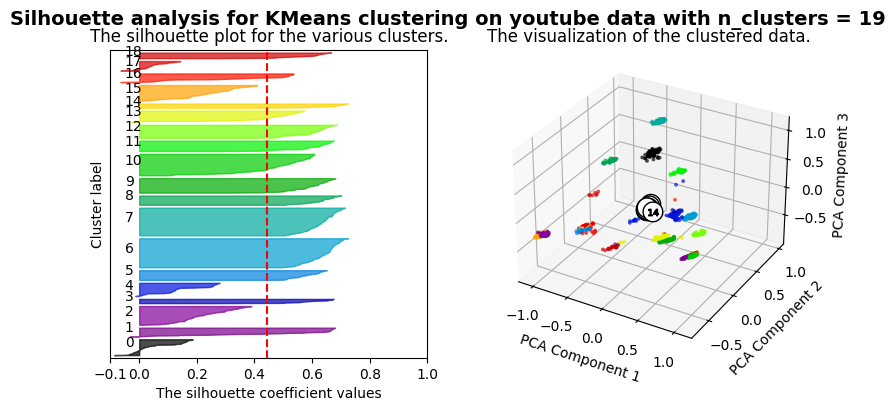

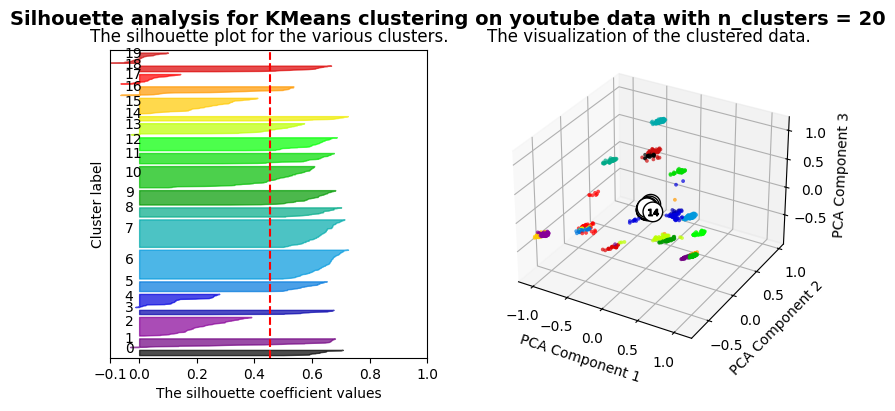

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

for n_clusters in range(2, 21):
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure(figsize=(9, 4))

    # The 1st subplot is the silhouette plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize kmeans with n_clusters value and a random generator seed for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    labels = kmeans.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    colors = cm.nipy_spectral(labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_[:,:3]  # We take only the first 3 components for cluster centers
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
                marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], c[2], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PCA Component 1")
    ax2.set_ylabel("PCA Component 2")
    ax2.set_zlabel("PCA Component 3")

    plt.suptitle(f"Silhouette analysis for KMeans clustering on youtube data with n_clusters = {n_clusters}", fontsize=14, fontweight='bold')

plt.show()

By plotting the silhouette score and the data we can see that with K = 16, the average silhouette_score is: 0.486, which is the maximum value.

It seems like the clustering is not doing very well, we assume that's because of the curse of dimensionality - the problem of all the pairwise distances between different points in the space converging to the same value as the dimensionality of the data increases. It also can be due to a few noisy features in the data that affect the clustering algorithm.

We'll try to fit the KMeans model to the X_pca - the dimension-reduced matrix with the assumption that even with 54.78% of the original variance, different samples will remain different from each other.

For n_clusters = 2, the average silhouette_score is: 0.36376943553282765
For n_clusters = 3, the average silhouette_score is: 0.507361302043792
For n_clusters = 4, the average silhouette_score is: 0.7052763195951175
For n_clusters = 5, the average silhouette_score is: 0.6840198946200468
For n_clusters = 6, the average silhouette_score is: 0.6850573940876652
For n_clusters = 7, the average silhouette_score is: 0.6687868120552768
For n_clusters = 8, the average silhouette_score is: 0.6641541292003653
For n_clusters = 9, the average silhouette_score is: 0.7010191472849712
For n_clusters = 10, the average silhouette_score is: 0.7499096432098196
For n_clusters = 11, the average silhouette_score is: 0.7830647069796847
For n_clusters = 12, the average silhouette_score is: 0.8194489494830767
For n_clusters = 13, the average silhouette_score is: 0.8288940045561906
For n_clusters = 14, the average silhouette_score is: 0.837388046594789
For n_clusters = 15, the average silhouette_score is: 0.8094

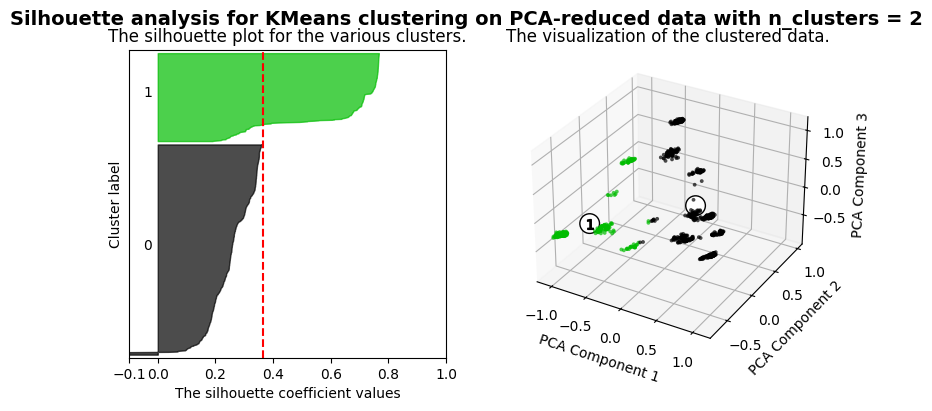

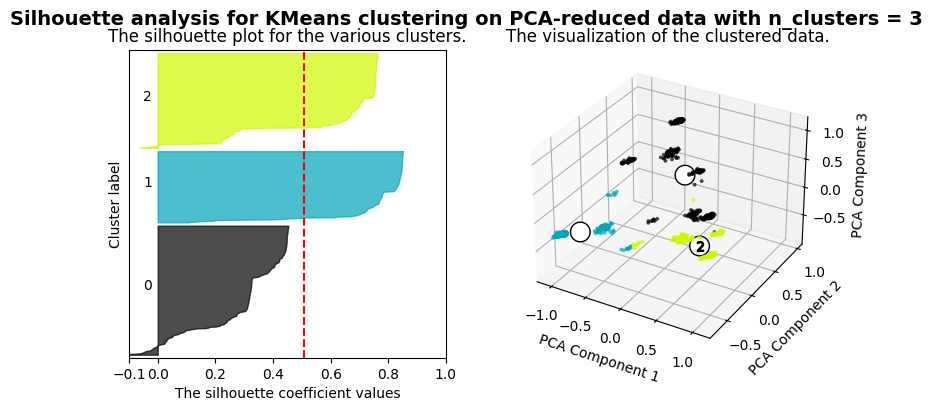

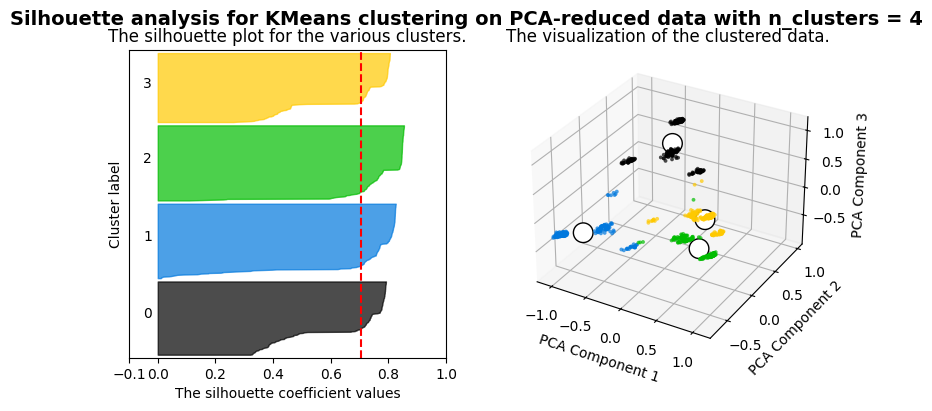

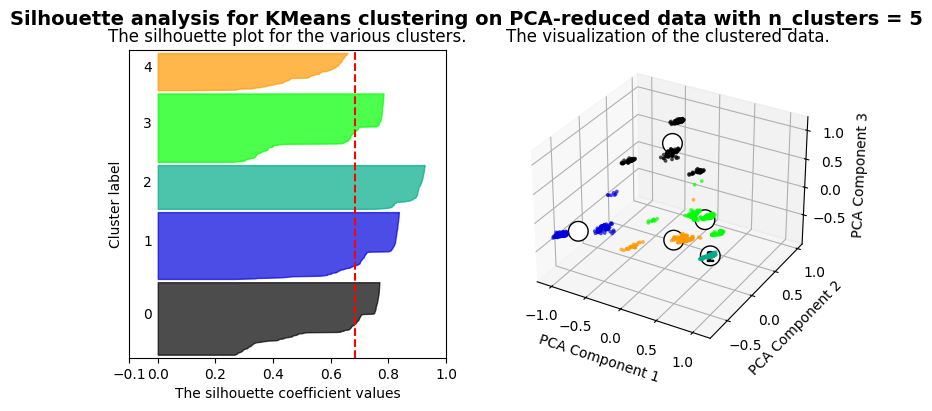

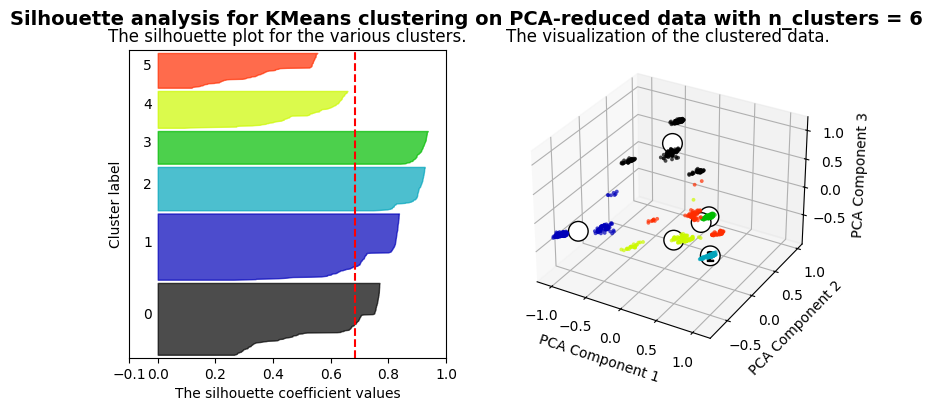

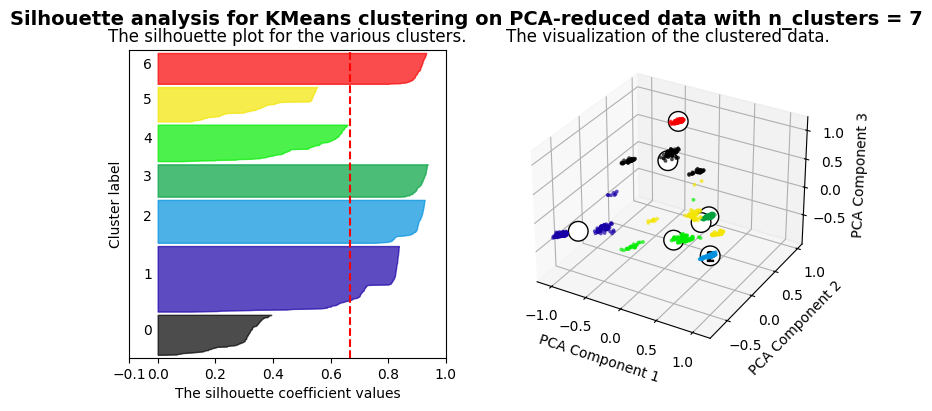

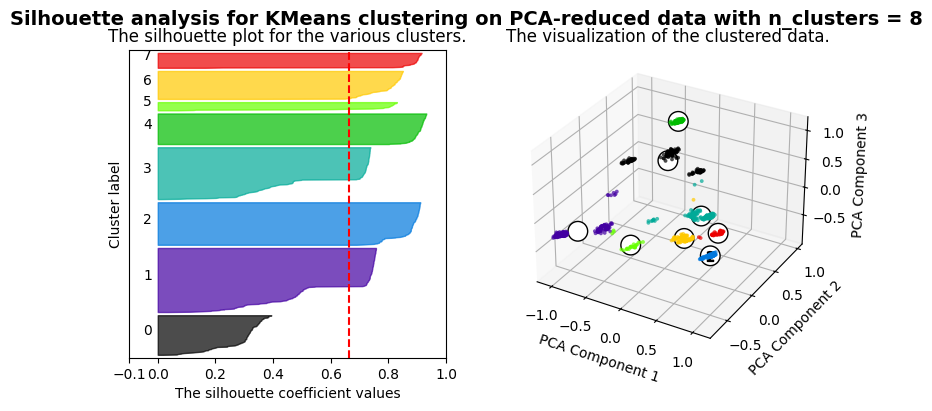

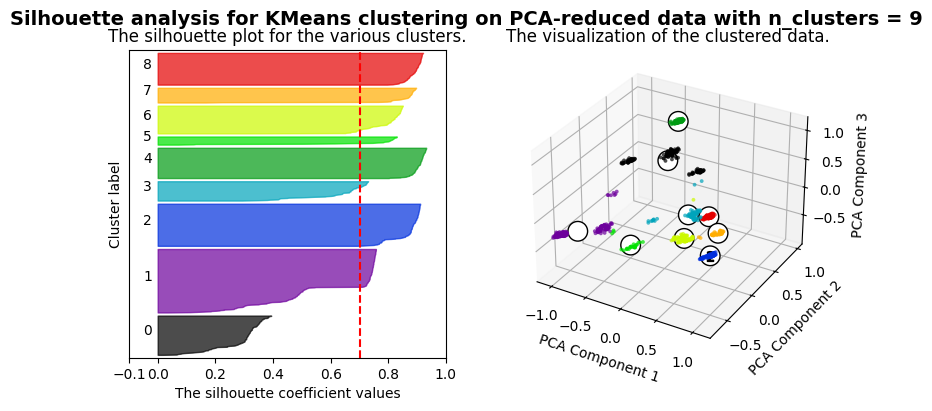

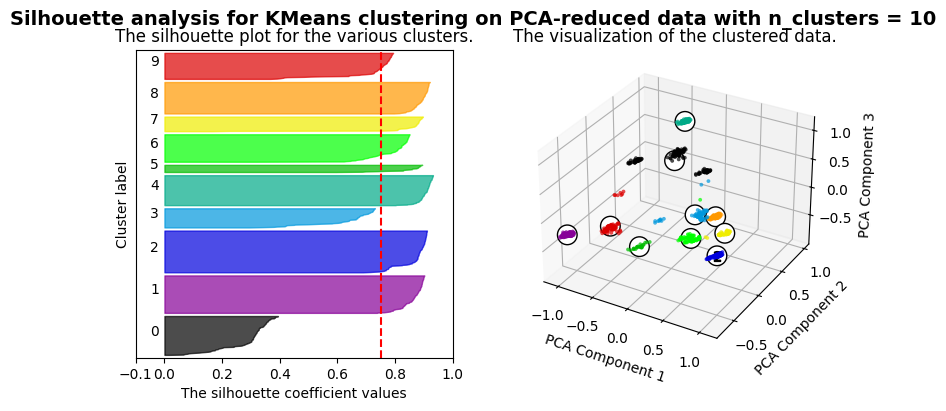

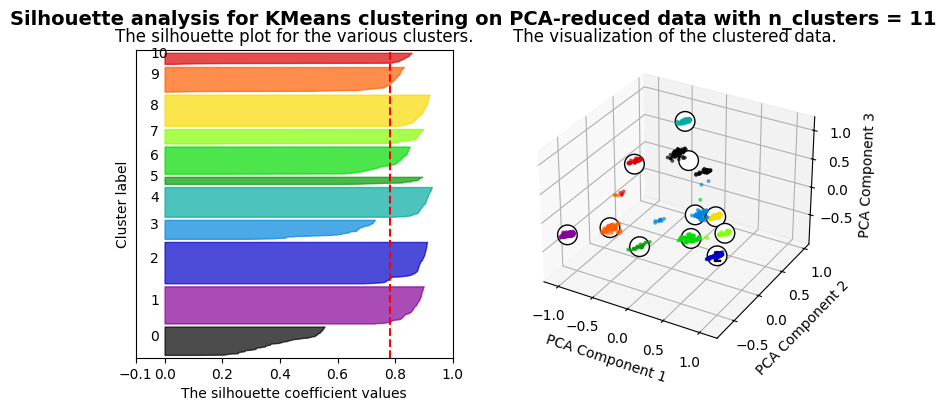

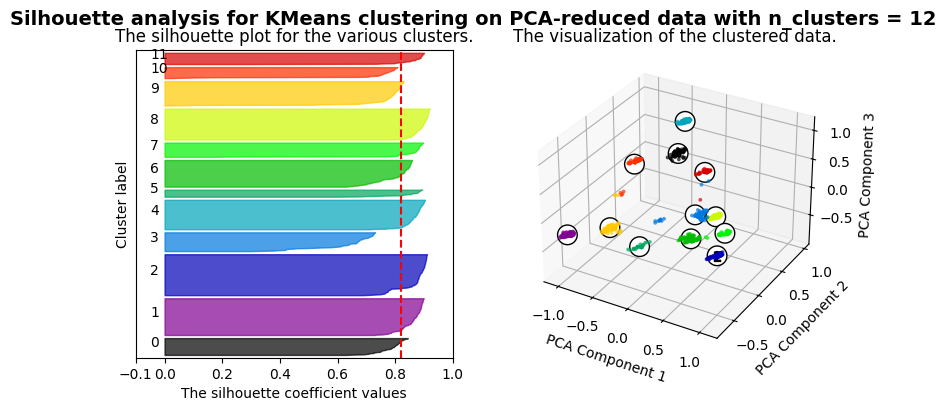

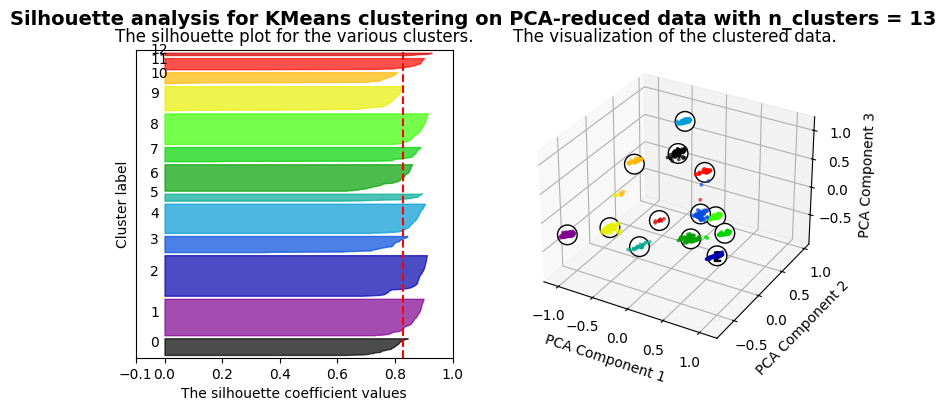

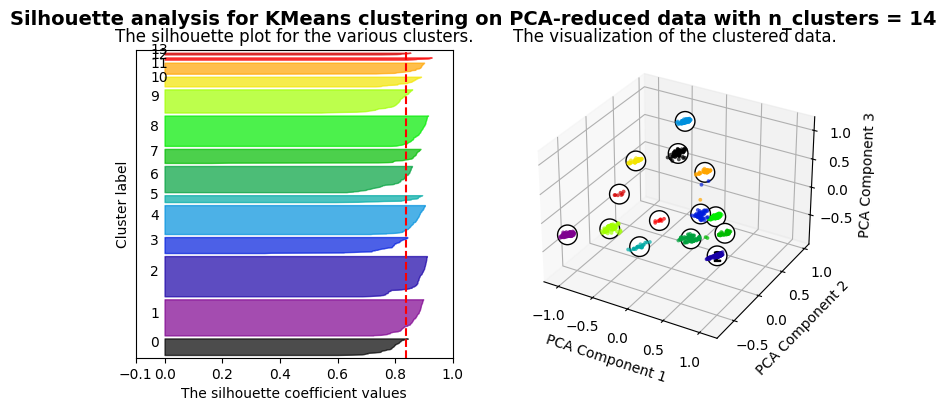

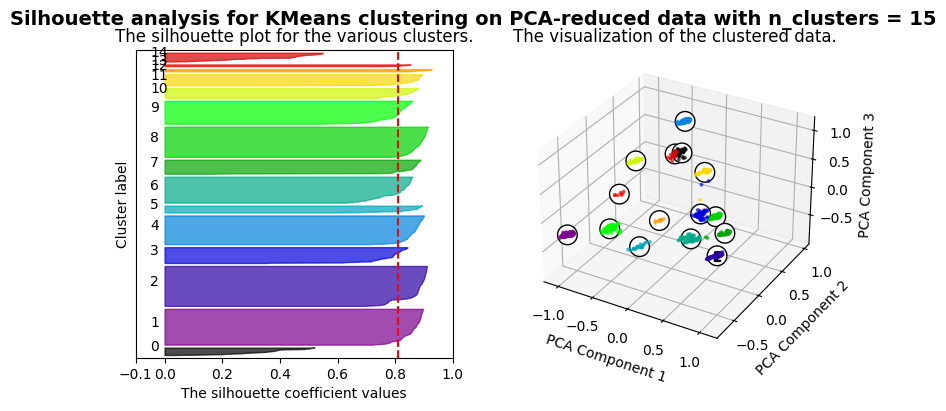

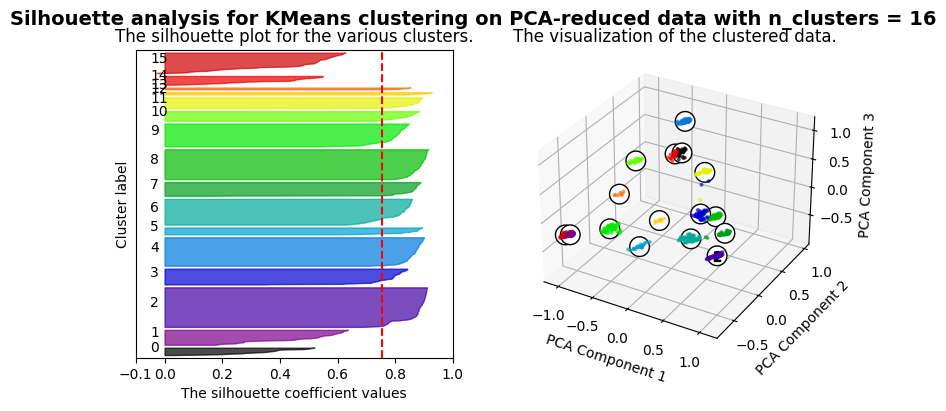

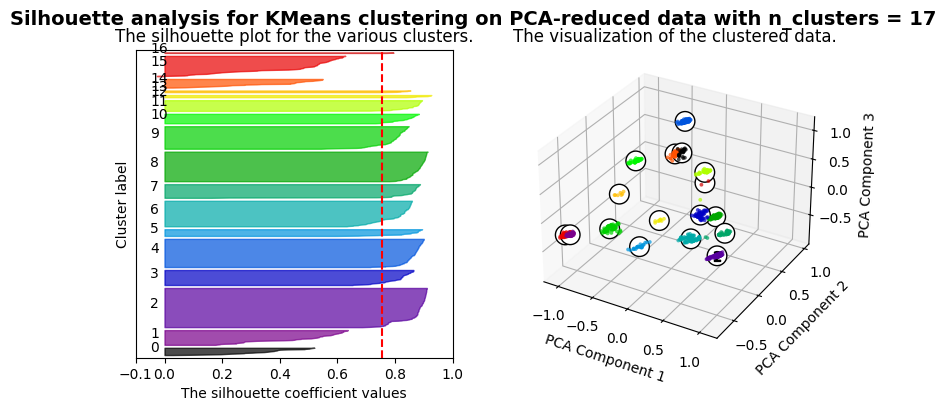

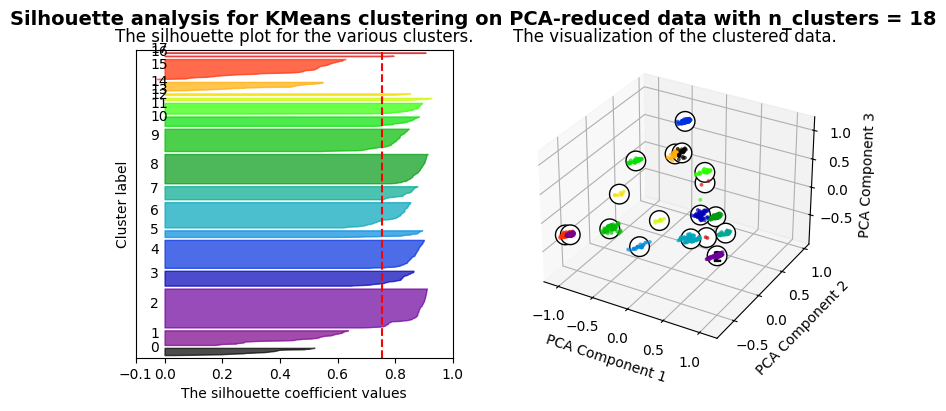

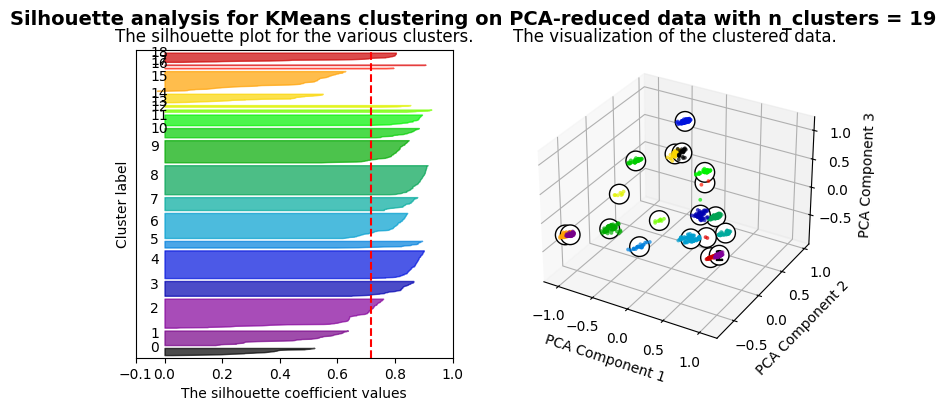

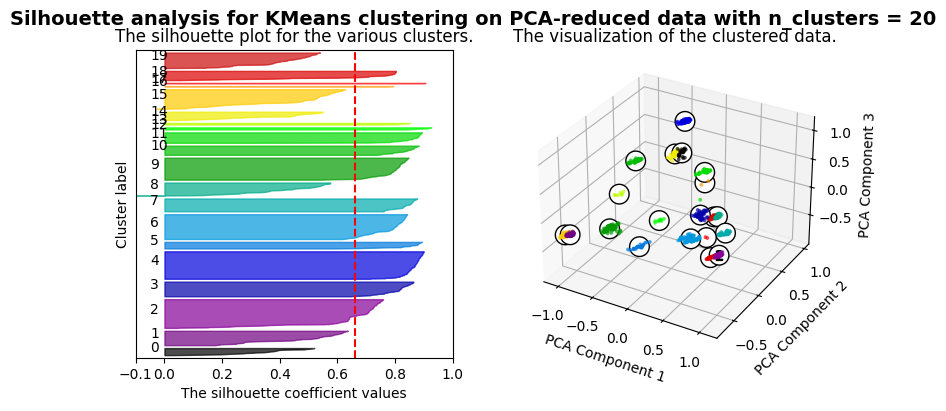

In [11]:
for n_clusters in range(2, 21):
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure(figsize=(9, 4))

    # The 1st subplot is the silhouette plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize kmeans with n_clusters value and a random generator seed for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
                marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], c[2], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PCA Component 1")
    ax2.set_ylabel("PCA Component 2")
    ax2.set_zlabel("PCA Component 3")

    plt.suptitle(f"Silhouette analysis for KMeans clustering on PCA-reduced data with n_clusters = {n_clusters}", fontsize=14, fontweight='bold')

plt.show()

The results we got make more sense - with K = 14, the silhouette score is 0.837, which is significantly higher than before. 

Let's plot it again

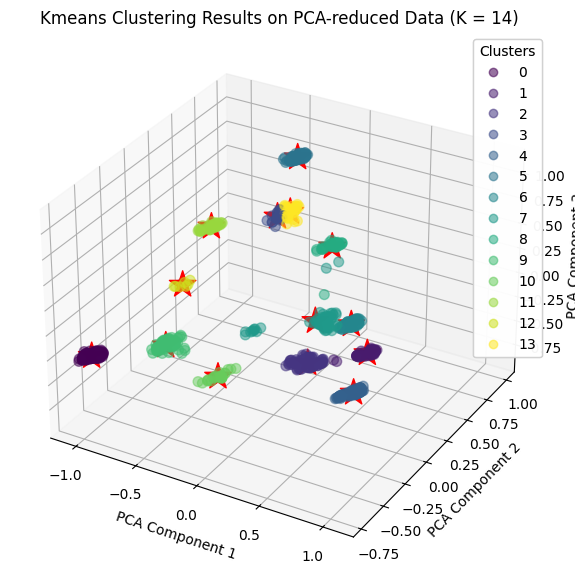

In [12]:
kmeans = KMeans(n_clusters=14)
labels = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_

# Plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis', s=50, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=400, alpha=1.0, marker='*')

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('Kmeans Clustering Results on PCA-reduced Data (K = 14)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.show()

Looking closer at the plot, we detect 3 samples that look outside the clusters.

The problem with KMeans is that the algorithm tries to cluster all  the samples, even the outliers (if there are any).

Let's try to apply DBSCAN, to see if we get better results at clustering, and if the 3 samples are indeed outliers - it will probably detect them.

#### DBSCAN

Another algorithm for clustering is DBSCAN. It's based on the density of a group of points. One advantage of DBSCAN is that it can also detect outliers. 

To find the best hyperparameters (eps and min_samples) for DBSCAN, We'll use a grid search - try every pair of hyperparameters and find the two that maximize the silhouette.

In [13]:
from sklearn.cluster import DBSCAN

def grid_search(combinations, X):
    scores = []
    all_labels = []
    for i, (eps, min_samples) in enumerate(combinations):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)
        labels = dbscan.labels_
        labels_set = set(labels)
        num_of_clusters = len(labels_set) - (1 if -1 in labels_set else 0)
        if num_of_clusters < 2:  # If there's only 1 cluster - skip
            scores.append(-10)
            all_labels.append('Bad')
            continue
        scores.append(silhouette_score(X, labels))
        all_labels.append(labels)

    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_score = scores[best_index]

    return {
        'best_epsilon': best_parameters[0],
        'best_min_samples': best_parameters[1],
        'best_silhouette_score': best_score
    }

In [14]:
epsilons = np.linspace(0.01, 2, 20)
min_samples = np.arange(2,10, step=1)

import itertools
combinations = list(itertools.product(epsilons, min_samples))  # Create a list of every pair of epsilon and min_sample

best_model = grid_search(combinations, X_pca)
print(best_model)

best_eps, best_min_samples = best_model['best_epsilon'], best_model['best_min_samples']

{'best_epsilon': 0.11473684210526315, 'best_min_samples': 3, 'best_silhouette_score': 0.8366412398581428}


By searching for every pair of epsilon and min_samples, we found the best hyperparameters with the highest silhouette score: 0.836 - similar to KMeans.

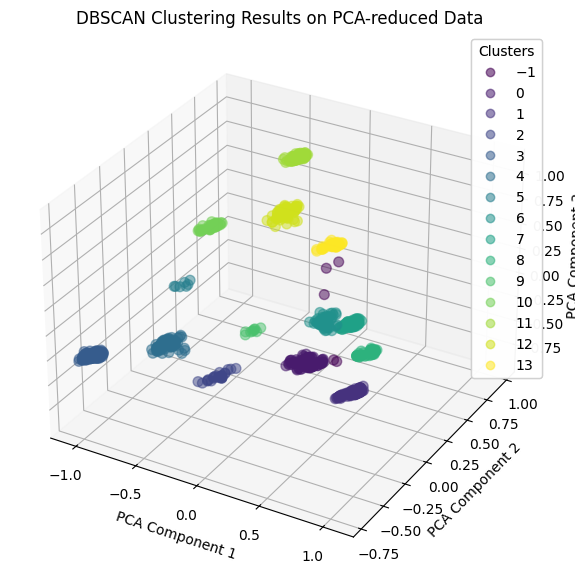

In [15]:
# Fit DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters = dbscan.fit_predict(X_pca)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the clusters based on the first three PCA components
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', s=50, alpha=0.5)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('DBSCAN Clustering Results on PCA-reduced Data')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.show()

In [16]:
print('Number of outliers detected by DBSCAN:', (clusters == -1).sum())
outliers_proportion = (clusters == -1).sum() / X_pca.shape[0]

Number of outliers detected by DBSCAN: 5


The results returned from DBSCAN algorithm are interesting.

Both KMeans and DBSCAN found 14 clusters in the data - with an average silhouette of 0.83.

But DBSCAN also found 5 outliers. Let's check that with other anomaly detection algorithms also.

In [17]:
# # Define a pipeline for preprocess, PCA and cluster with KMeans
# kmeans_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),  # Preprocess the data
#     ('pca', PCA(n_components=3)),    # Add PCA as the final step
#     ('KMeans', KMeans(n_clusters=14)) 
# ])

# kmeans_pipeline.fit(youtube_data)
# pickle.dump(kmeans_pipeline, open("kmeans_pipeline.pkl","wb"))
# pickle.dump(X_pca, open("X_pca.pkl","wb"))

### Step 4:
## Anomaly Detection

We will try to detect anomalies with different kinds of algorithms, and plot the results.

The contamination percentage calculated above from DBSCAN 

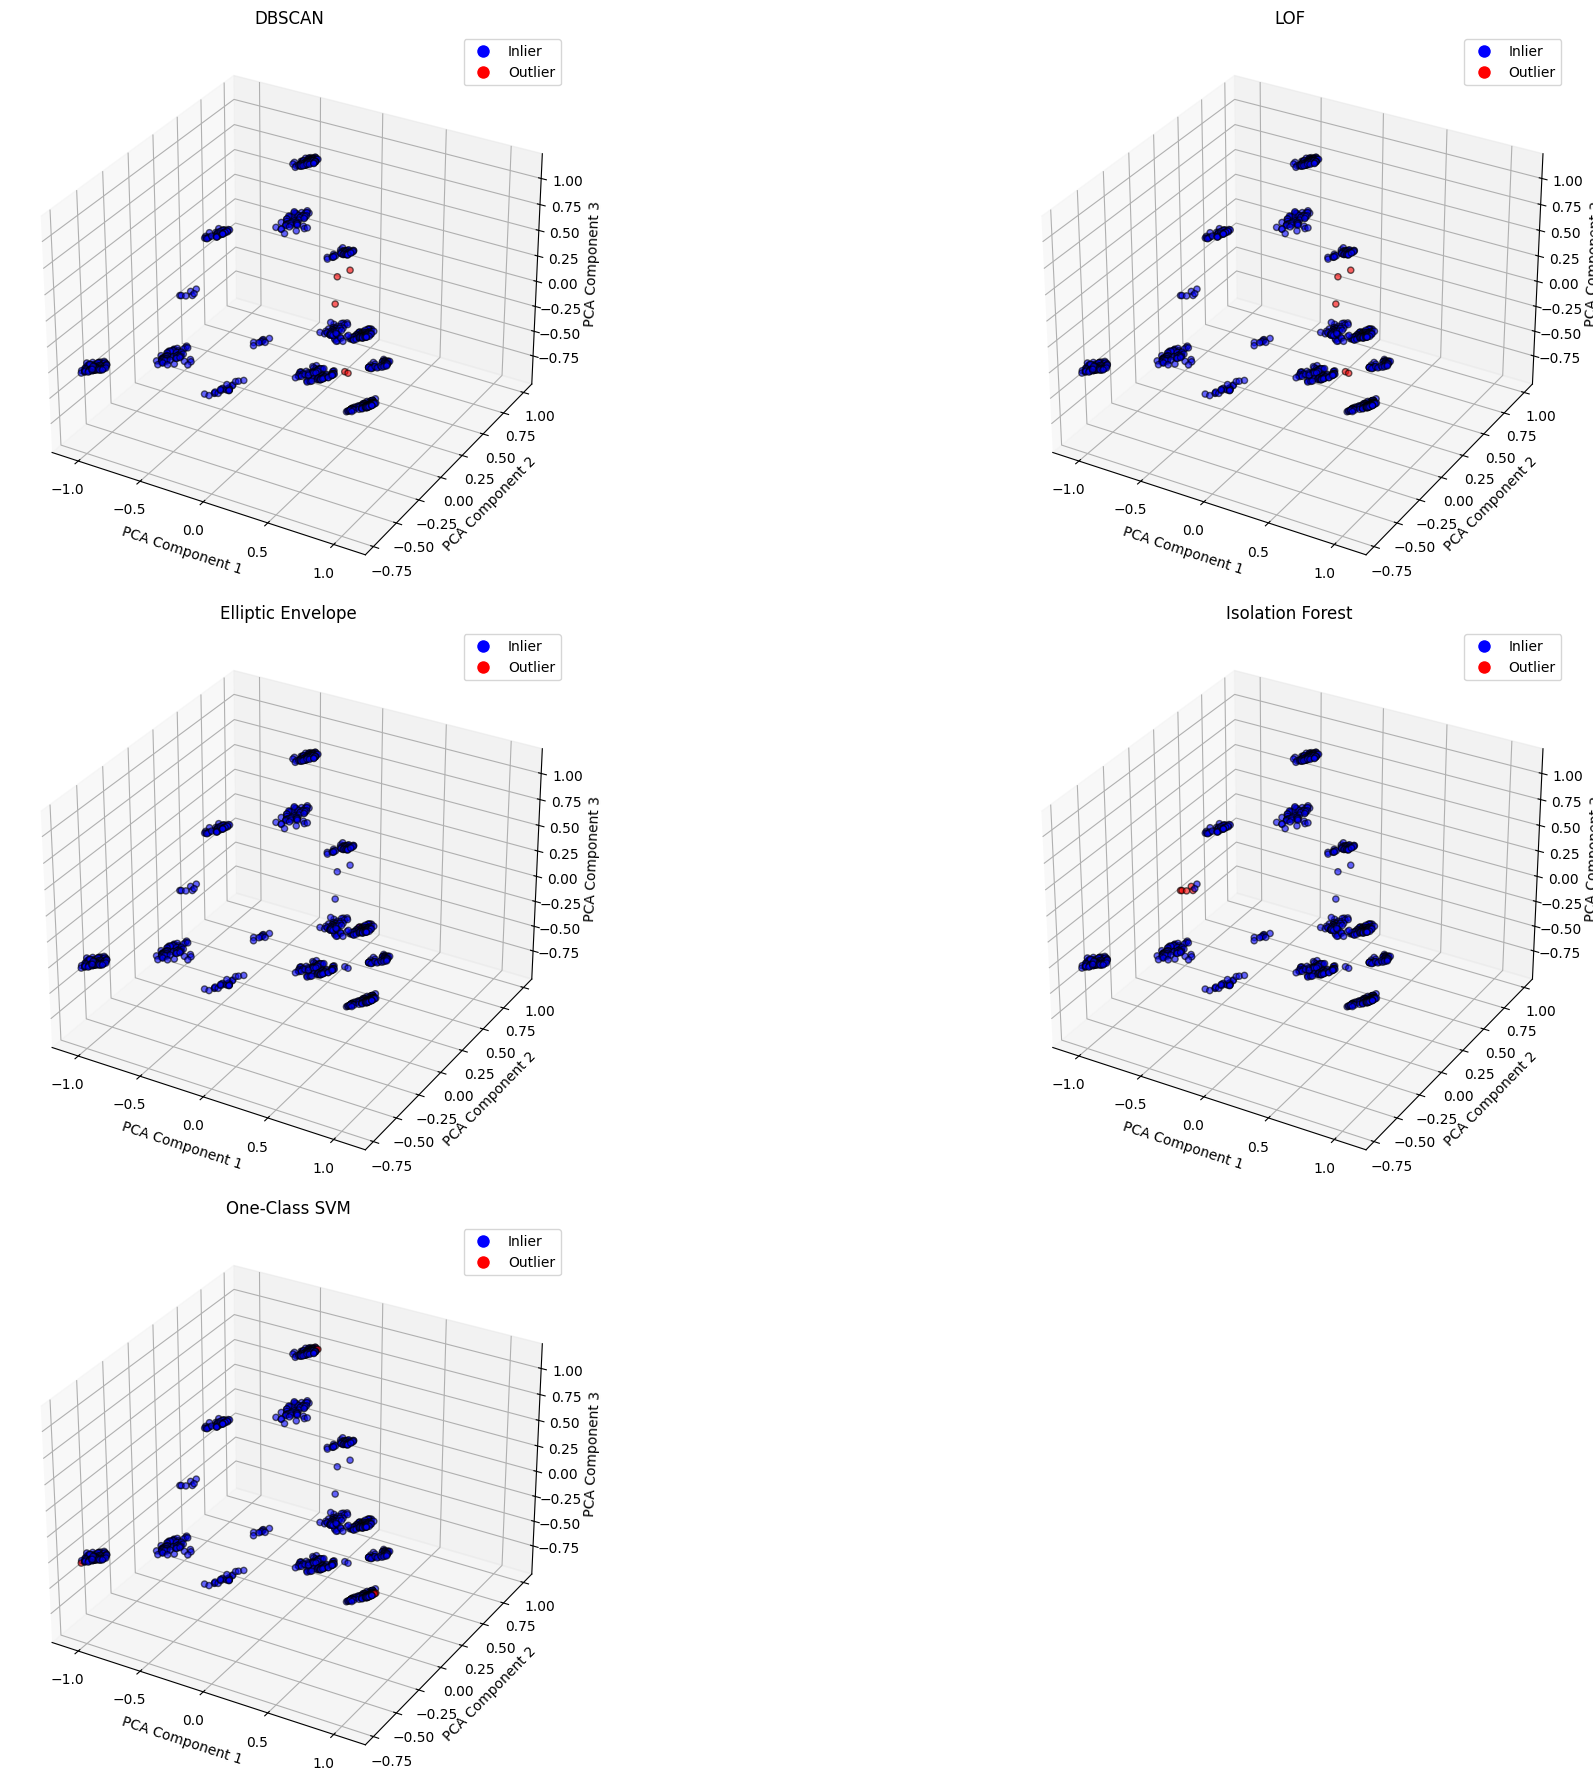

In [18]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from matplotlib.lines import Line2D

models = {
    'DBSCAN': DBSCAN(eps=best_eps, min_samples=best_min_samples), 
    'LOF': LocalOutlierFactor(contamination=outliers_proportion, n_neighbors=20),
    'Elliptic Envelope': EllipticEnvelope(contamination=outliers_proportion, support_fraction=1., random_state=42),
    'Isolation Forest': IsolationForest(contamination=outliers_proportion, n_estimators=100, random_state=42),
    'One-Class SVM': OneClassSVM(kernel='rbf', gamma='auto', nu=outliers_proportion)
}

# Setup for visualization
fig = plt.figure(figsize=(22, 18))  # Adjust figure size for 3 rows
axes = [fig.add_subplot(3, 2, i+1, projection='3d') for i in range(6)]  # 3x2 grid for 5 models + 1 hidden

# Define color map: -1 (outlier) -> red, 1 (inlier) -> blue, for models except DBSCAN
cmap = {-1: 'red', 1: 'blue'}

for i, (name, model) in enumerate(models.items()):
    ax = axes[i]
    
    # Fit and predict, adjusting for DBSCAN's outlier label
    if name == 'DBSCAN':
        preds = model.fit_predict(X_pca)
        colors = np.array([cmap.get(label, 'blue') for label in preds])
    else:
        if hasattr(model, "fit_predict"):
            preds = model.fit_predict(X_pca)
        else:
            model.fit(X_pca)
            preds = model.predict(X_pca)
        colors = np.array(['red' if x == -1 else 'blue' for x in preds])

    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=colors, alpha=0.6, edgecolor='k')
    
    # Add legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inlier'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Outlier')]
    ax.legend(handles=legend_elements, loc='upper right')
    
    ax.set_title(name)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')

# Hide the last subplot to make a clean layout
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

Only DBSCAN and Local Outlier Factor (out of 5 models) have detected those 5 samples as anomalies. 

This is not enough for classify those samples as outliers.